## Step 1 - Loading the dependencies

On this notebook, we will generate item-item recommendations using a technique called https://en.wikipedia.org/wiki/Collaborative_filtering. Let's get started!

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Step 2: Load the Data

Let's download a small version of the MovieLens dataset. You can access it via the zip file url http://files.grouplens.org/datasets/movielens/ml-latest-small.zip, or directly download here. We're working with data in ml-latest-small.zip and will need to add the following files to our local directory:


In [2]:
ratings = pd.read_csv("data/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies = pd.read_csv("data/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Step 3: Exploratory Data Analysis

In Part 1 of this tutorial series, we will focus on the ratings dataset. We'll need movies for subsequent sections. Ratings contains users' ratings for a given movie. Let's see how many ratings, unique movies, and unique users are in our dataset.



In [4]:
n_ratings =len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()


print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37



Now, let's take a look at users' rating counts. We can do this using pandas' groupby() and count() which groups the data by userId's and counts the number of ratings for each userId

In [5]:
user_freq = ratings[['userId','movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44
...,...,...
605,606,1115
606,607,187
607,608,831
608,609,37


In [6]:
user_freq['n_ratings'].mean()

165.30491803278687

On average, a user will have rated ~165 movies. Looks like we have some avid movie watchers in our dataset.

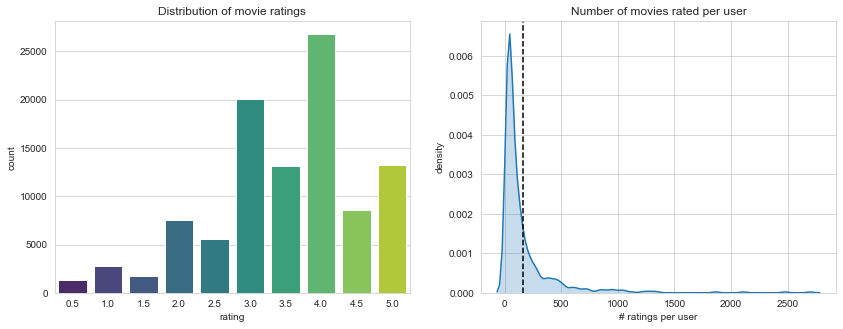

In [7]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()


The most common rating is 4.0, while lower ratings such as 0.5 or 1.0 are much more rare.

### Which movie has the lowest and highest average rating?

In [8]:
Which movie has the lowest and highest average rating

SyntaxError: invalid syntax (<ipython-input-8-9a0800614c2f>, line 1)

In [ ]:
lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]

In [ ]:

highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

In [ ]:
ratings[ratings['movieId']==highest_rated]

## Step 4: Transforming the data

We will be using a technique called collaborative filtering to generate user recommendations. This technique is based on the assumption of "homophily" - similar users like similar things. Collaborative filtering is a type of unsupervised learning that makes predictions about the interests of a user by learning from the interests of a larger population.

The first step of collaborative filtering is to transform our data into a user-item matrix - also known as a "utility" matrix. In this matrix, rows represent users and columns represent items. The beauty of collaborative filtering is that it doesn't require any information about the users or items to generate recommendations


The create_X() function outputs a sparse matrix X with four mapper dictionaries:

user_mapper: maps user id to user index
movie_mapper: maps movie id to movie index
user_inv_mapper: maps user index to user id
movie_inv_mapper: maps movie index to movie id
We need these dictionaries because they map which row and column of the utility matrix corresponds to which user ID and movie ID, respectively.

The X (user-item) matrix is a scipy.sparse.csr_matrix which stores the data sparsely.

In [10]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [11]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

Let's check out the sparsity of our X matrix.

Here, we calculate sparsity by dividing the number of non-zero elements by total number of elements as described in the equation below:

$$S=\frac{\text{# non-zero elements}}{\text{total elements}}$$

In [12]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


Matrix sparsity: 1.7%
Only 1.7% of cells in our user-item matrix are populated with ratings. But don't be discouraged by this sparsity! User-item matrices are typically very sparse. A general rule of thumb is that your matrix sparsity should be no lower than 0.5% to generate decent results.

Writing your matrix to a file
We're going to save our user-item matrix for the next part of this tutorial series. Since our matrix is represented as a scipy sparse matrix, we can use the scipy.sparse.save_npz method to write the matrix to a file.

In [14]:
from scipy.sparse import save_npz

save_npz('data/user_item_matrix.npz', X)

## Step 5: Finding similar movies using k-Nearest Neighbours

This approach looks for the $k$ nearest neighbours of a given movie by identifying $k$ points in the dataset that are closest to movie $m$. kNN makes use of distance metrics such as:

Cosine similarity

Euclidean distance

Manhattan distance

Pearson correlation

Although difficult to visualize, we are working in a M-dimensional space where M represents the number of movies in our X matrix